# HW1: LeNet-5 with Post-training Quantization and Quantization Aware Training
[LeNet](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) is considered to be the first ConvNet.
We are going to implement a neural architecture similar to LeNet and train it with [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.

Before we start, you may check this [Tensorspace-LeNet](https://tensorspace.org/html/playground/lenet.html) to play with LeNet and get familiar with this neural architecture.

![image](https://production-media.paperswithcode.com/methods/LeNet_Original_Image_48T74Lc.jpg)
Ref.: LeCun et al., Gradient-Based Learning Applied to Document Recognition, 1998a

<font color='red'>Name: 潘勝元 Student ID: 109062116 </font>

## 1. Initial Setup

We are goint to implement and train this nerual network with PyTorch 
If you are not familer with PyTorch, check [official tutorail](https://pytorch.org/tutorials/beginner/basics/intro.html)

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [5]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
import numpy as np
import random
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#!pip install torchinfo

cuda:0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 Load dataset
Load training and test data from the MNIST dataset.

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
    ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2,
                                          worker_init_fn=seed_worker, generator=g,)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2,
                                         worker_init_fn=seed_worker, generator=g,)

### 1.2 Define the Neural Network 
Define a simple CNN that classifies MNIST images.

In [7]:
from collections import OrderedDict
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(1, 6, 5, bias=False)),
            ('relu', nn.ReLU()),
        ]))
        
        self.maxpool2 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        
        self.conv3 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(6, 16, 5, bias=False)),
            ('relu', nn.ReLU())
        ]))
        
        self.maxpool4 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        
        self.conv5 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(16, 120, 5, bias=False)),
            ('relu', nn.ReLU())
        ]))
        
        self.fc6 = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(120, 84, bias=False)),
            ('relu', nn.ReLU())
        ]))
        
        self.output = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(84, 10, bias=False)),
        ]))
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool4(x)
        x = self.conv5(x)
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        x = self.output(x)
        return x

NET = Net().to(device)

### 1.3 Question: Profile the Neural Architecture by TorchInfo
Torchinfo provides information complementary to what is provided by print(your_model) in PyTorch, similar to Tensorflow's model.summary() API to view the visualization of the model, which is helpful while debugging your network. Check this [link](https://github.com/TylerYep/torchinfo#how-to-use) about how to use TorchInfo by `summary()` and fill in the TODO in the following cell. You should get the result similar to the table below:

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
LeNet                                    --                        --
...
...
==========================================================================================
Total params: ...
...
Estimated Total Size (MB): ...
==========================================================================================
```


Ref.: https://github.com/TylerYep/torchinfo

Please read *B. LeNet-5* in the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) and answer the following questions.
1. What is the type (convolution, pooling, fully-connected layer, etc.), input activation size, output activation size, and activation function (if any) of each layer?
2. What is the difference part between this neural architecture and the lenet-5 in the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)?
3. Could we replace the 3rd conv, the conv in conv5, with a fully connected layer?

### 1.3 Answers
<font color='red'>Write your answers here.</font>
1. 假設batch size = 1 
  activation size的算法是將shape的數字都乘起來。
  layer1:convolution,1028(1(batch size),1,32,32),4704(1,6,28,28),RELU   
  layer2:pooling,4704(1,6,28,28),1176(1,6,14,14)     
  layer3:convolution,1176(1,6,14,14),1600(1,16,10,10),RELU    
  layer4:pooling,1600(1,16,10,10),400(1,16,5,5)     
  layer5:convolution,400(1,16,5,5),120(1,120,1,1),RELU,    
  layer6:fully-connected layer,120(1,120,1,1),84(1,84),RELU     
  layer7:fully-connected layer,84(1,84),10(1,10)
2. 在output layer的部分，我們的model是使用fully connected layer的方式，而原本的paper是使用Euclidean Radial Basis Function units(RBF)。
3. 可以，因為kernel size和input size都是5*5，使用fully connected layer有相同效果。

In [8]:
from torchinfo import summary
# TODO
net1 = Net()
summary(net1,input_size=(1, 1, 32 , 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 6, 28, 28]            --
│    └─Conv2d: 2-1                       [1, 6, 28, 28]            150
│    └─ReLU: 2-2                         [1, 6, 28, 28]            --
├─Sequential: 1-2                        [1, 6, 14, 14]            --
│    └─MaxPool2d: 2-3                    [1, 6, 14, 14]            --
├─Sequential: 1-3                        [1, 16, 10, 10]           --
│    └─Conv2d: 2-4                       [1, 16, 10, 10]           2,400
│    └─ReLU: 2-5                         [1, 16, 10, 10]           --
├─Sequential: 1-4                        [1, 16, 5, 5]             --
│    └─MaxPool2d: 2-6                    [1, 16, 5, 5]             --
├─Sequential: 1-5                        [1, 120, 1, 1]            --
│    └─Conv2d: 2-7                       [1, 120, 1, 1]            48,000
│    └─

### 1.4 Train and Test the Neural Network
Train this CNN on the training dataset (this may take a few moments).
* Check how to save and load the model
    * https://pytorch.org/tutorials/beginner/saving_loading_models.html
    * Save:
        ```
        torch.save(model.state_dict(), PATH)
        ```
    * Load:
        ```
        model = TheModelClass(*args, **kwargs)
        model.load_state_dict(torch.load(PATH))
        model.eval()
        ```
* After training the model, we will save it as `lenet.pt`.
* You should comment out `train(NET, trainloader, 2)` and uncomment `NET.load_state_dict(torch.load('lenet.pt'))` before submitting your homework.
    * Also, reloading the model from `lenet.pt` can save your time if there is something wrong and you need to restart and run all.

In [9]:
def train(model: nn.Module, dataloader: DataLoader, num_epoch):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader):
            
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        print(test(model, testloader, None))
    print('Finished Training')
    
def test(model: nn.Module, dataloader: DataLoader, max_samples=None, device=device) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += inputs.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total

In [10]:
#train(NET, trainloader, 2)
NET.load_state_dict(torch.load('lenet.pt'))
score = test(NET, testloader, None)
print('Accuracy of the network on the test images: {}%'.format(score))

torch.save(NET.state_dict(), 'lenet.pt')

Accuracy of the network on the test images: 98.92%


In [11]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.modules(), model.modules()):
        if isinstance(result_layer, (nn.Conv2d, nn.Linear)):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            
        if hasattr(original_layer, 'inAct'):
            result_layer.inAct = deepcopy(original_layer.inAct)
        if hasattr(original_layer, 'outAct'):
            result_layer.outAct = deepcopy(original_layer.outAct)
        if hasattr(original_layer, 'output_scale'):
            result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

## 2. Post-training Quantization
### 2.1 Question: Visualize Weights

We have flattened all vector for you by `tensor.view(-1)`.

Try plotting a histogram of each weight and show the total range and 3-sigma range for each weight.

hint: `np.histogram()` and `plt.hist()`

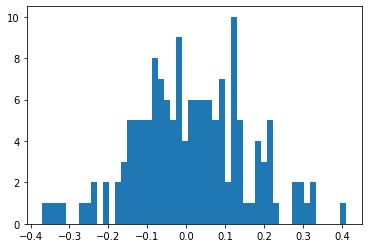

total range: 0.7823901772499084 from -0.37052456 to 0.41186562
three sigma range: 0.8713697791099548 from -0.4239271879196167 to 0.44744259119033813


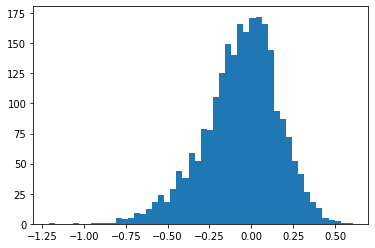

total range: 1.8173847198486328 from -1.2109491 to 0.60643566
three sigma range: 1.3489525318145752 from -0.7375973463058472 to 0.611355185508728


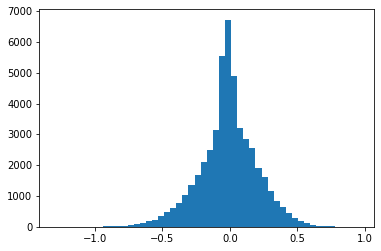

total range: 2.255288600921631 from -1.2984394 to 0.9568492
three sigma range: 1.2827434539794922 from -0.6541403532028198 to 0.6286031007766724


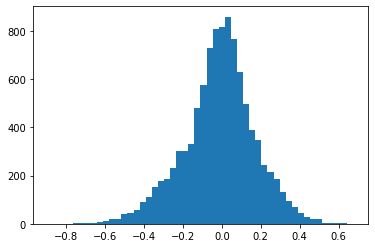

total range: 1.5640497207641602 from -0.8917776 to 0.6722721
three sigma range: 1.1030151844024658 from -0.5643313527107239 to 0.5386838316917419


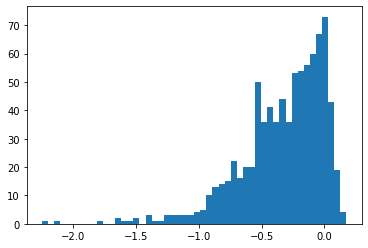

total range: 2.4234235286712646 from -2.247601 to 0.17582247
three sigma range: 2.0099949836730957 from -1.3333276510238647 to 0.676667332649231


In [12]:
import matplotlib.pyplot as plt

conv1_weights = NET.conv1[0].weight.data.cpu().view(-1)
conv2_weights = NET.conv3[0].weight.data.cpu().view(-1)
conv3_weights = NET.conv5[0].weight.data.cpu().view(-1)
fc1_weights = NET.fc6[0].weight.data.cpu().view(-1)
fc2_weights = NET.output[0].weight.data.cpu().view(-1)

weightDict = {
    'conv1_weights':conv1_weights, 
    'conv2_weights': conv2_weights, 
    'conv3_weights': conv3_weights, 
    'fc1_weights': fc1_weights, 
    'fc2_weights':fc2_weights
}

# TODO
for key,weight in weightDict.items():
  a,b=(np.histogram(weight,bins=50))
  Max = b[-1]
  Min = b[0]
  total_range = Max-Min
  three_sigma_range = (torch.mean(weight) - 3 * torch.std(weight), torch.mean(weight) + 3 * torch.std(weight))
  plt.hist(weight,50)
  plt.show()
  print("total range:",total_range.item(),"from",Min,"to",Max)
  print("three sigma range:",three_sigma_range[1].item()-three_sigma_range[0].item(),"from",three_sigma_range[0].item(),"to",three_sigma_range[1].item())

### 2.2 Question:  Quantize Weights
Computation of convolution or fully-connected layer can be expressed as
$$W\times I = O$$
where $W$ is the weight tensor, $I$ is the input tensor, and $O$ is the output tensor.
Let $n_w$ be the scaling factor. We have $$W_q\times I =n_w W \times I\approx n_w O$$ where $W_q$ is the quantized 8-bit signed integer weight tensor.

Fill in the TODO in `quantized_weights()`.If you’ve done everything correctly, the accuracy degradation should be negligible(~1%).
1. What is $n_w$? Explain how you get it.
2. What is the accuracy degradation? \
Show both relative error and absolute error when the true value is the accuracy we get before performing any quanitzion.

### 2.2 Answers
<font color='red'>Write your answers here.</font>
1. nw是我們在進行quantizec後要在縮放回原本的range的倍率。   
  因為是symmetric quantization所以我們先從total_range取絕對值得最大值x，我們原本的range設定為-x至x，然後將這個range的總長度除以-128至127(目標的range)的總長度，然後這是fix轉成float的scaler，所以我們取倒數就是nw了。
2. accuracy degradation是我們在進行quantized後，捨棄了小數點的部分，所以導致精準度的下降。   
  absolute error: 98.92 - 98.91 = 0.01   
  relative error: 0.01 / 98.92 = 1.011e-4 

In [13]:
net_q2 = copy_model(NET)

In [14]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    Use the total range when deciding just what factors to scale the float32 
    values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
        * The weights in quantized form, where every value is an integer between -128 and 127.
          The "dtype" will still be "float", but the values themselves should all be integers.
        * The scaling factor that your weights were multiplied by.
          This value does not need to be an 8-bit integer.
    '''

    # TODO
    # Adopt the symmetric quantization by the total range
    wmax = torch.max(weights)
    wmin = torch.min(weights)
    wmin = -wmin
    xf_max = torch.max(wmax,wmin)
    S = xf_max*2/255
    S = 1/S
    qweights=torch.round(weights*S)
    qweights=torch.where(qweights>=128,127,qweights)
    return qweights, S

In [15]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [16]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 98.91%


### 2.3 Question: Visualize Activations
Plot histograms of the input images and the output activations of each operation and answer the following questions.
1. Discuss any observations about the distribution of these activations.
2. Record the range of the values, as well as their 3-sigma range (the difference between μ + 3σ and μ − 3σ).

### 2.3 Answers
<font color='red'>Write your answers here.</font>
1. 除了第一層與最後一層以外，其他層的range都是從0開始。  
  除了最後一層外，其他層的data大多位於range最左邊。  
2.   
  total range: 1.984313726425171 from -1.0 to 0.9843137  
  three sigma range: 3.522346019744873 from -2.484403610229492 to 1.0379424095153809 
   
  total range: 2.1659035682678223 from 0.0 to 2.1659036  
  three sigma range: 1.5503243207931519 from -0.6854264736175537 to 0.8648978471755981   

  total range: 4.587000846862793 from 0.0 to 4.587001  
  three sigma range: 2.4688878059387207 from -1.1300053596496582 to 1.3388824462890625  

  total range: 9.805818557739258 from 0.0 to 9.805819  
  three sigma range: 9.40185546875 from -4.2335052490234375 to 5.1683502197265625  

  total range: 11.374738693237305 from 0.0 to 11.374739  
  three sigma range: 12.047304153442383 from -5.239156723022461 to 6.808147430419922  

  total range: 32.52015686035156 from -33.211838 to -0.6916796  
  three sigma range: 67.73571014404297 from -53.08457565307617 to 14.651134490966797

In [17]:
net_q3 = copy_model(NET)

def visualize_activations(module, input, output):
    if module.profile_activations is True:
        module.inAct = input[0].cpu().reshape(-1)
        module.outAct = output[0].cpu().reshape(-1)
    
for name, model in net_q3.named_children():
    print("{}\n [register_forward_hook]: {}".format(name, model))
    model.profile_activations = True
    model.register_forward_hook(visualize_activations)
net_q3.eval()
with torch.no_grad():
    input = trainset[0][0].unsqueeze(0)
    _ = net_q3(input.to(device))   
for name, model in net_q3.named_children(): 
    model.profile_activations = False 

conv1
 [register_forward_hook]: Sequential(
  (conv): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (relu): ReLU()
)
maxpool2
 [register_forward_hook]: Sequential(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)
conv3
 [register_forward_hook]: Sequential(
  (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (relu): ReLU()
)
maxpool4
 [register_forward_hook]: Sequential(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)
conv5
 [register_forward_hook]: Sequential(
  (conv): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (relu): ReLU()
)
fc6
 [register_forward_hook]: Sequential(
  (fc): Linear(in_features=120, out_features=84, bias=False)
  (relu): ReLU()
)
output
 [register_forward_hook]: Sequential(
  (fc): Linear(in_features=84, out_features=10, bias=False)
)


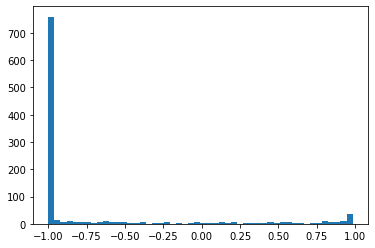

total range: 1.984313726425171 from -1.0 to 0.9843137
three sigma range: 3.522346019744873 from -2.484403610229492 to 1.0379424095153809


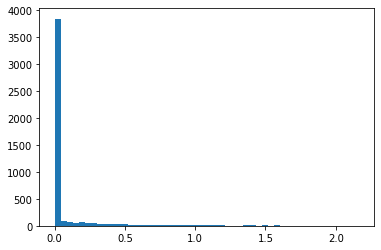

total range: 2.1659035682678223 from 0.0 to 2.1659036
three sigma range: 1.5503243207931519 from -0.6854264736175537 to 0.8648978471755981


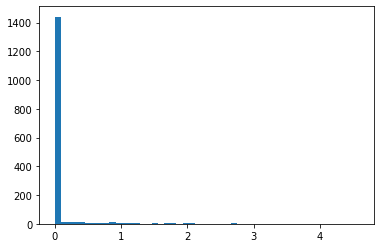

total range: 4.587001323699951 from 0.0 to 4.5870013
three sigma range: 2.4688878059387207 from -1.1300053596496582 to 1.3388824462890625


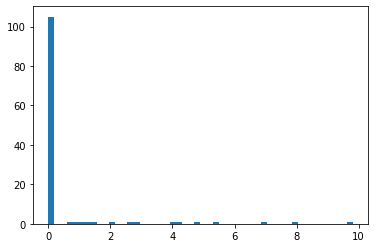

total range: 9.80582046508789 from 0.0 to 9.80582
three sigma range: 9.401857376098633 from -4.233506202697754 to 5.168351173400879


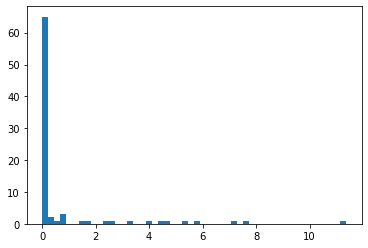

total range: 11.374739646911621 from 0.0 to 11.37474
three sigma range: 12.047306060791016 from -5.239157676696777 to 6.808148384094238


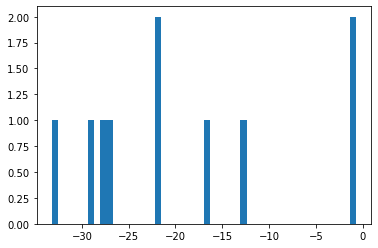

total range: 32.52015686035156 from -33.211838 to -0.69168067
three sigma range: 67.73571014404297 from -53.08457565307617 to 14.651134490966797


In [18]:
input_activations = net_q3.conv1.inAct
conv1_output_activations = net_q3.conv1.outAct
conv3_output_activations = net_q3.conv3.outAct
conv5_output_activations = net_q3.conv5.outAct
fc6_output_activations = net_q3.fc6.outAct
output_output_activations = net_q3.output.outAct

actDict = {
    'input_activations':input_activations, 
    'conv1_output_activations':conv1_output_activations, 
    'conv3_output_activations':conv3_output_activations, 
    'conv5_output_activations':conv5_output_activations, 
    'fc6_output_activations':fc6_output_activations, 
    'output_output_activations':output_output_activations
}

# TODO
for key,act in actDict.items():
  a,b=(np.histogram(act,bins=50))
  Max = b[-1]
  Min = b[0]
  total_range = Max-Min
  three_sigma_range = (torch.mean(act) - 3 * torch.std(act), torch.mean(act) + 3 * torch.std(act))
  plt.hist(act,50)
  plt.show()
  print("total range:",total_range.item(),"from",Min,"to",Max)
  print("three sigma range:",three_sigma_range[1].item()-three_sigma_range[0].item(),"from",three_sigma_range[0].item(),"to",three_sigma_range[1].item())

### 2.4 Question:  Quantize Activations
The output of conv in conv1 can be $$W_{conv1}\times I=O_{conv1}.$$
Let the scaling factor of the quantized input matrix $I$ be $n_I$, the scaling factor of the quantized weight matrix $W_{conv1}$ 
be $n_{W_{conv1}}$, and the scaling factor of the output matrix $O_{conv1}$ be $n_{O_{conv1}}$.  
$$W_{conv1_q}\times I_q = (n_{W_{conv1}}W_{conv1})\times (n_II)\approx (n_{W_{conv1}}n_I)O_{conv1}$$
where $W_{conv1_q}$ is the quantized 8-bit signed integer weight tensor and $I_q$ is the quantized 8-bit signed integer input activation tensor.

$$O_{conv1_q} \approx n_{O_{conv1}}O_{conv1}$$
where $O_{conv1_q}$ is the quantized 8-bit signed integer output activation tensor.

Since we're doing post-training quantization, we can get $n_I$, $n_{W_{conv1}}$, and $n_{O_{conv1}}$ first and do the other calculations for quantization.

As for `forward()` of `NetQuantized()`, make sure you can simulate fixed-point representation when doing any calculation with input/output scale. Keep in mind that we will implement hardware to accelerate this model with fixed-point computations.
   * In this assignment, we only "emulate" fixed-point computations. We don't need to use any fixed-point data type (e.g., `int`).
   * You will have to fill in the TODO in `forward()` to scale the outputs of each layer. Consider rounding binary fractions to the 16th place with the following steps (e.g., for output_scale): 
- Initial input:
   To scaling the initial input, you can simply perform `round(scale)*features` since `input_scale` is much greater than 1.
- the convolution/fully connected layer:
       1. `scale = round(scale*(2**16))`: Now, we have the `scale` rounded to the 16th place with a software trick of moving the binary point (`*(2**16)`) and applying the round function.
       2. emulating bit-shifting in fixed-point numbers instead of floating-point numbers by either of the following:
        1.	`floor(input × scale >> 16)`
        2.	`int(input × scale >> 16)`
       4. Clamp the value between -128 and 127
    
    

Answer the following questions.

1. How to compute $n_I$, $n_{W_{conv1}}$, and $n_{O_{conv1}}$? 
2. The ture quantized output activation tensor is depend on $W_{conv1_q}$ and $I_q$, so we cannot simply apply only $n_{O_{conv1}}$ on the output of $W_{conv1_q}\times I_q$ to quantize output activation. \
Derive an equation for the quantized output of the conv in conv1 after quantizing activation and weight with  $n_I$, $n_{W_{conv1}}$, and $n_{O_{conv1}}$ and show the scaling factor $S_1$ of it. \
(hint: re-quantize $O'$ in $W_{conv1_q}\times I_q = O'$.That is to have $S_1(W_{conv1_q}\times I_q) \approx S_1O' = O_{conv1_q}$ where $O_{conv1_q}$ is the quantized 8-bit signed integer output.)
3. Derive an equation for the quantized output of the conv in conv3 after quantizing activation and weight.
4. Show the general equantion of each layer for calculating the scaling factor of output activation.
5. Fill in the TODO in the following code.If you’ve done everything correctly, the accuracy degradation should be negligible(~1%). What is the accuracy degradation? Show both relative error and absolute error when the true value is the accuracy we get before performing any quanitzion.

### 2.4 Answers
<font color='red'>Write your answers here.</font>
1. nI : 除了initial input要quantized(255/torch.max(torch.max(I),-torch.min(I)))外都是取前一個layer的output scalar.  
  nWconv1 :與initial input的算法相同(255/torch.max(torch.max(W),-torch.min(W)))   
  nOconv1 :與initial input的算法相同(255/torch.max(torch.max(O),-torch.min(O)))   
2. S1(nWconvl * nI * Wconv1×I) = nOconvl * Oconv1 = Oconvq1  
  Oconv1q = Wconv1*I * nOconv1   
  S1 = nOconvl / nWconvl / nI
3. Oconv3q = Wconv3 * Omaxpooling2 * nOconv3   
  S3 = nOconv3 / nWmaxpool2 / nI
4. S = nO / nW / nI
5. accuracy degradation是我們在進行quantized後，捨棄了小數點的部分，所以導致精準度的下降。   
  absolute error: 98.92 - 98.84 = 0.08   
  relative error: 0.01 / 98.92 = 8.087e-4 


In [19]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()
        
        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.maxpool2 = net_init.maxpool2
        self.conv3 = net_init.conv3
        self.maxpool4 = net_init.maxpool4
        self.conv5 = net_init.conv5
        self.fc6 = net_init.fc6
        self.output = net_init.output

        for layer in self.conv1, self.conv3, self.conv5, self.fc6, self.output:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))
            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.conv1.inAct
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv3, self.conv5, self.fc6, self.output:
            layer.output_scale = NetQuantized.quantize_activations(layer.outAct, layer[0].weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer[0].weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # TODO
        rmax = torch.max(torch.max(pixels),-torch.min(pixels))
        S = rmax*2/255


        return 1/S

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, n_s: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        n_s ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''
        # TODO
        rmax = torch.max(torch.max(activations),-torch.min(activations))
        S = rmax*2/255
        S = 1/S
        M = n_initial_input
        for i in n_s:
          M = M * i[0] * i[1]
        M = M * n_w
        S = S / M
        
        return S

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Since input_scale is 128 and all output_scales are less than 1, we should keep input_scale as it is and tranform output_scale to 
        round(1/output_scale) to ease the verilog implementaion.
        
        Also, the normalized input images is a matrix with lots of floating numbers. We can transform x*input_scale to
        input_scale/round(1/x)
        
        To not implement rounding in verilog, we use floor when doing other calculations with input/output_scale.
        '''
        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.Tensor.floor
        #   * torch.clamp

        # TODO
        
        x = torch.Tensor.round(self.input_scale)/torch.round(1/x)
        x = torch.Tensor.floor(x)
        x = self.conv1(x)
        S = torch.Tensor.round(self.conv1.output_scale*(2**16))
        x = torch.Tensor.floor((x*S)/(2**16))
        x = torch.clamp(x, -128, 127)
        x = self.maxpool2(x)
        x = self.conv3(x)
        
        S = torch.Tensor.round(self.conv3.output_scale*(2**16))
        x = torch.Tensor.floor((x*S)/(2**16))
        x = torch.clamp(x, -128, 127)
    
        x = self.maxpool4(x)
        x = self.conv5(x)

        S = torch.Tensor.round(self.conv5.output_scale*(2**16))
        x = torch.Tensor.floor((x*S)/(2**16))
        x = torch.clamp(x, -128, 127)
        
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        S = torch.Tensor.round(self.fc6.output_scale*(2**16))
        x = torch.Tensor.floor((x*S)/(2**16))
        x = torch.clamp(x, -128, 127)
        x = self.output(x)
        S = torch.Tensor.round(self.output.output_scale*(2**16))
        x = torch.Tensor.floor((x*S)/(2**16))
        x = torch.clamp(x, -128, 127)  
        return x

In [20]:
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.conv1.inAct)
        
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    layer_init.inAct = deepcopy(layer_q3.inAct)
    layer_init.outAct = deepcopy(layer_q3.outAct)

net_quantized = NetQuantized(net_init)

In [21]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 98.84%


Answer the following questions.(hint: please consider verilog implementation):

6. What is the benefit of using `floor`?
7. What is the benefit of replacing `x*output_scale`with `x/round(1/output_scale)`?

### 2.4 Answers
<font color='red'>Write your answers here.</font>
6. 我們可以保證得到的數字是向下取的整數，而round計算可能會產生小數。verilog的計算是以整數去算的，所以floor用在verilog會比較好。
7. 好處是轉成整數後運算速度比較快且可以減少誤差。

In [22]:
print("input_scale:\n", net_quantized.input_scale.item())
print("output_scale:\n {}\n {}\n {}\n {}\n {}".format(
    net_quantized.conv1.output_scale.item(),
    net_quantized.conv3.output_scale.item(),
    net_quantized.conv5.output_scale.item(),
    net_quantized.fc6.output_scale.item(),
    net_quantized.output.output_scale.item()
))

print("input_scale:\n", net_quantized.input_scale.item())
print("output_scale:\n {}\n {}\n {}\n {}\n {}".format(
    round(1/net_quantized.conv1.output_scale.item()),
    round(1/net_quantized.conv3.output_scale.item()),
    round(1/net_quantized.conv5.output_scale.item()),
    round(1/net_quantized.fc6.output_scale.item()),
    round(1/net_quantized.output.output_scale.item())
))

input_scale:
 127.49999237060547
output_scale:
 0.0014914418570697308
 0.004484623204916716
 0.004763831850141287
 0.006029605399817228
 0.006037507671862841
input_scale:
 127.49999237060547
output_scale:
 670
 223
 210
 166
 166


### 2.5 Question:  Quantize Biases
We add a bias in the final layer of this LeNet.
* You should comment out `train(NET_WITH_BIAS, trainloader, 2)` and uncomment `NET_WITH_BIAS.load_state_dict(torch.load('lenet_with_bias.pt'))` before submitting your homework.
    * Also, reloading the model from `lenet_with_bias.pt` can save your time if there is something wrong and you need to restart and run all.

Answer the following questions.
1. Now the equation is $$W*I+\beta = O$$ where $\beta$ is the bias. Derive the equation of a quantized layer with bias.\
Note that our biases are commonly quantized to 32-bits
2. What is the scaling factor for the bias?\
(hint: the form looks just like what we have done for quantizing activations)
3. Fill in the TODO in the following code.If you’ve done everything correctly, the accuracy degradation should be negligible(~1%). What is the accuracy degradation?\
Show both relative error and absolute error when the true value is the accuracy we get before performing any quanitzion.

### 2.5 Answers
<font color='red'>Write your answers here.</font>
1. W = Wq / nW, I = Iq / nI,O = Oq/nO  
  Wq*Iq/nW/nI +Bq/nB = Oq/nO  
  Bq = (Oq/nO-Wq*Iq/nW/nI)nB
2. S = 1 / nW / nI
3. absolute error 98.57-98.45 = 0.12%   
   relative error 0.12/98.57 = 1.2e-3=0.12%

In [23]:
class NetWithBias(Net):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.output = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(84, 10, bias=True)),
        ]))
    
NET_WITH_BIAS = NetWithBias().to(device)

In [24]:
#train(NET_WITH_BIAS, trainloader, 2)
NET_WITH_BIAS.load_state_dict(torch.load('lenet_with_bias.pt'))
score = test(NET_WITH_BIAS, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))
torch.save(NET_WITH_BIAS.state_dict(), 'lenet_with_bias.pt')

Accuracy of the network (with a bias) on the test images: 98.57%


In [25]:
for name, model in NET_WITH_BIAS.named_children():
    print("{}\n [register_forward_hook]: {}".format(name, model))
    model.profile_activations = True
    model.register_forward_hook(visualize_activations)
NET_WITH_BIAS.eval()
with torch.no_grad():
    input = trainset[0][0].unsqueeze(0)
    _ = NET_WITH_BIAS(input.to(device))
for name, model in NET_WITH_BIAS.named_children(): model.profile_activations = False 

conv1
 [register_forward_hook]: Sequential(
  (conv): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (relu): ReLU()
)
maxpool2
 [register_forward_hook]: Sequential(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)
conv3
 [register_forward_hook]: Sequential(
  (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (relu): ReLU()
)
maxpool4
 [register_forward_hook]: Sequential(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)
conv5
 [register_forward_hook]: Sequential(
  (conv): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (relu): ReLU()
)
fc6
 [register_forward_hook]: Sequential(
  (fc): Linear(in_features=120, out_features=84, bias=False)
  (relu): ReLU()
)
output
 [register_forward_hook]: Sequential(
  (fc): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
net_with_bias_with_quantized_weights = copy_model(NET_WITH_BIAS)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 98.54%


In [27]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)
        preceding_scales = [
            (self.conv1[0].weight.scale, self.conv1.output_scale),
            (self.conv3[0].weight.scale, self.conv3.output_scale),
            (self.conv5[0].weight.scale, self.conv5.output_scale),
            (self.fc6[0].weight.scale, self.fc6.output_scale),
            (self.output[0].weight.scale, self.output.output_scale)
        ][:-1]
        
        self.output[0].bias.data = NetQuantizedWithBias.quantized_bias(
            self.output[0].bias.data,
            self.output[0].weight.scale,
            self.input_scale,
            preceding_scales
        )

        if (self.output[0].bias.data < -2147483648).any() or (self.output[0].bias.data > 2147483647).any():
            raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.output[0].bias.data != self.output[0].bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, n_s: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between -2147483648 and 2147483647.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        n_s ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between -2147483648 and 2147483647.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''

        # TODO
        # --------------------------------------------------------------------
        # The quantization way are similar to quantize output activation
        # --------------------------------------------------------------------
        M = n_initial_input
        for i in n_s:
          M = M * i[0] * i[1]
        M = M * n_w
        bias = bias /  M
        return torch.clamp((bias).round(), min=-2147483648, max=2147483647)

In [28]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

In [29]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights and the bias are quantized: 98.45%


## 3. Quantization Aware Training (QAT)
* You should comment out `train(model_fp32_prepared, trainloader, 2)` and uncomment `model_fp32_prepared.load_state_dict(torch.load('model_fp32_prepared.pt'))` before submitting your homework.
    * Also, reloading the model from `model_fp32_prepared.pt` can save your time if there is something wrong and you need to restart and run all.

### 3.1 Question: 
Try to trace code and study the quantization-aware training (QAT) from [Quantization — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/quantization.html), then answer the following question.

1. How can the QAT achieve a higher accuracy than the post-training quantization (PTQ)?
2. What does the function model_fp32_fused do to improve precision and speed?
3. Two more layers (quant, dequant) appeared after we quantized our model using the PyTorch QAT method. What do these two layers do?

### 3.1 Answers
<font color='red'>Write your answers here.</font>
1. 因為QAT會在training的過程中模擬quantization的效益並進行調整，而PTQ在一開始預測完後就部會再調整了，所以比較準。
2. model_fp32_fused將activation與前面的layer結合一起計算，因為一起計算可以減少round類型的操作增加accuracy，而減少存取次數可以增加速度。
3. QuantStub()負責將floating point轉成quantized，而DeQuantStub()會將quantized再轉回floating point。這兩個layer會加進去各層layer中使用。

In [30]:
class QATNet(NetWithBias):
    def __init__(self):
        super().__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.quantization.QuantStub()
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)
        x = self.dequant(x)
        return x
    
MODEL_FP32 = QATNet().to(device)
print(MODEL_FP32)

MODEL_FP32.eval()
print(MODEL_FP32)

MODEL_FP32.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
MODEL_FP32_FUSED = torch.quantization.fuse_modules(MODEL_FP32,
    [['conv1.conv', 'conv1.relu'], 
     ['conv3.conv', 'conv3.relu'],
     ['conv5.conv', 'conv5.relu'],
     ['fc6.fc', 'fc6.relu'],
    ])
MODEL_FP32_FUSED = MODEL_FP32
# Specify quantization configuration
MODEL_FP32_FUSED.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')
print(MODEL_FP32_FUSED.qconfig)

model_fp32_prepared = torch.quantization.prepare_qat(MODEL_FP32_FUSED.train())

#train(model_fp32_prepared, trainloader, 2)
model_fp32_prepared.load_state_dict(torch.load('model_fp32_prepared.pt'))
score = test(model_fp32_prepared, testloader)
print('Accuracy of the model_fp32_prepared: {}%'.format(score))
torch.save(model_fp32_prepared.state_dict(), 'model_fp32_prepared.pt')

QATNet(
  (conv1): Sequential(
    (conv): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (relu): ReLU()
  )
  (maxpool2): Sequential(
    (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (relu): ReLU()
  )
  (maxpool4): Sequential(
    (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (conv): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (relu): ReLU()
  )
  (fc6): Sequential(
    (fc): Linear(in_features=120, out_features=84, bias=False)
    (relu): ReLU()
  )
  (output): Sequential(
    (fc): Linear(in_features=84, out_features=10, bias=True)
  )
  (quant): QuantStub()
  (dequant): DeQuantStub()
)
QATNet(
  (conv1): Sequential(
    (conv): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (relu): ReLU()
  )
  (maxpool2): Se

/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/fake_quantize.py:309: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:45.)
  return torch.fused_moving_avg_obs_fake_quant(
/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/fake_quantize.py:309: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:568.)
  return torch.fused_moving_avg_obs_fake_quant(


Accuracy of the model_fp32_prepared: 98.3%


In [31]:
# model_fp32_prepared

In [32]:
model_fp32_prepared = model_fp32_prepared.to('cpu')
model_fp32_prepared.eval()
qat = torch.quantization.convert(model_fp32_prepared, inplace=False)


# Extract the input and output of the quantized model

In [33]:
# copy the model with bias quantized model and save the weights
inference_model = copy_model(qat)

In [34]:
# Use accuray to make sure it is same model
score = test(inference_model, testloader, None, torch.device('cpu'))
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 98.3%


Use an image as an input of the activations，and choose 100 images to generate patterns for our homework 2.

In [35]:
# random choose images as the input and get the output
np.random.seed(0)
index = np.random.randint(0,len(trainset), size=100)
index = range(100)

Save the activations of input and output to the CSV format.

In [36]:
import os 
import zipfile
# It is easier to download all the files with zip
zf = zipfile.ZipFile('parameters.zip', 'w', zipfile.ZIP_DEFLATED)

if not os.path.exists('./activations'):
    os.mkdir('./activations')

In [37]:
for ind in range(100):
    if not os.path.exists('./activations/img{}'.format(ind)):
        os.mkdir('./activations/img{}'.format(ind))

    for name, model in qat.named_children():
        model.profile_activations = True
        model.register_forward_hook(visualize_activations)
    input0, label = testset[index[ind]]
    input = input0.reshape(1, 1, 32, 32)
    output = qat(input)
    for name, model in qat.named_children(): model.profile_activations = False 
    

    np.savetxt('./activations/img{}/input.csv'.format(ind), input.cpu().data.numpy().reshape(-1), delimiter=',')
    np.savetxt('./activations/img{}/output.csv'.format(ind), output.cpu().data.numpy().reshape(-1).astype(int), delimiter=',')
    zf.write('./activations/img{}/input.csv'.format(ind))
    zf.write('./activations/img{}/output.csv'.format(ind))
    
    opDict = {
        'conv1': (qat.conv1.inAct, qat.conv1.outAct),
        'maxpool2': (qat.maxpool2.inAct, qat.maxpool2.outAct),
        'conv3': (qat.conv3.inAct, qat.conv3.outAct),
        'maxpool4': (qat.maxpool4.inAct, qat.maxpool4.outAct),
        'conv5': (qat.conv5.inAct, qat.conv5.outAct),
        'fc6': (qat.fc6.inAct, qat.fc6.outAct),
        'quant': (qat.quant.inAct, qat.quant.outAct),
        'dequant': (qat.dequant.inAct, qat.dequant.outAct),
        'output': (qat.output.inAct, qat.output.outAct)
    }
    
    for key in opDict:
        if not os.path.exists('./activations/img{}/{}'.format(ind, key)):
            os.mkdir('./activations/img{}/{}'.format(ind, key))
        if(opDict[key][0].type()== "torch.quantized.QInt8Tensor" or opDict[key][0].type()== "torch.quantized.QUInt8Tensor"):
            temp = opDict[key][0].cpu().int_repr()
        else:
            temp = opDict[key][0].cpu()
        if(opDict[key][1].type()== "torch.quantized.QInt8Tensor" or opDict[key][1].type()== "torch.quantized.QUInt8Tensor"):
            temp1 = opDict[key][1].cpu().int_repr()
        else:
            temp1 = opDict[key][1].cpu()                
        np.savetxt('./activations/img{}/{}/input.csv'.format(ind, key), temp.data.numpy().reshape(-1).astype(float), delimiter=',')
        np.savetxt('./activations/img{}/{}/output.csv'.format(ind, key), temp1.cpu().data.numpy().reshape(-1).astype(float), delimiter=',')
        zf.write('./activations/img{}/{}/input.csv'.format(ind, key))
        zf.write('./activations/img{}/{}/output.csv'.format(ind, key))

Save each layer's weights, zero point and scaling factor to the CSV format.

In [38]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')
if not os.path.exists('./weights/scale'):
    os.mkdir('./weights/scale')
if not os.path.exists('./weights/weight'):
    os.mkdir('./weights/weight')
if not os.path.exists('./weights/zero_point'):
    os.mkdir('./weights/zero_point')
for name, weights in qat.state_dict().items():
    name_split = name.split('.')
    if weights!= None:
        if name_split[-2] != "_packed_params":
            if(weights.type()== "torch.quantized.QInt8Tensor" or weights.type()== "torch.quantized.QUInt8Tensor"):
                np.savetxt('./weights/weight/%s.csv' %(name) , weights.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
                zf.write('./weights/weight/%s.csv' %(name))

                np.savetxt('./weights/weight/%s.scale.csv' %(name) , weights.q_per_channel_scales().numpy().reshape(-1).astype(float), delimiter=',')
                zf.write('./weights/weight/%s.scale.csv' %(name))

                np.savetxt('./weights/weight/%s.zero_point.csv' %(name) , weights.q_per_channel_zero_points().cpu().numpy().reshape(-1).astype(float), delimiter=',')
                zf.write('./weights/weight/%s.zero_point.csv' %(name))
            else:
                np.savetxt('./weights/%s/%s.csv'%(name_split[-1],name) , weights.cpu().numpy().reshape(-1).astype(float), delimiter=',')
                zf.write('./weights/%s/%s.csv'%(name_split[-1],name))

          
          
        elif name_split[-1] == "_packed_params":
            if not os.path.exists('./weights/_packed_params'):
                os.mkdir('./weights/_packed_params')
            weight, bias = weights
            name = name_split[0]+"."+name_split[1]
            if(weight.type()== "torch.quantized.QInt8Tensor" or weight.type()== "torch.quantized.QUInt8Tensor"):
                np.savetxt('./weights/weight/%s.weight.csv' %(name)  , weight.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
                zf.write('./weights/weight/%s.weight.csv' %(name))

                np.savetxt('./weights/weight/%s.weight.scale.csv' %(name) , weight.q_per_channel_scales().cpu().numpy().reshape(-1).astype(float), delimiter=',')
                zf.write('./weights/weight/%s.weight.scale.csv' %(name))

                np.savetxt('./weights/weight/%s.weight.zero_point.csv' %(name) , weight.q_per_channel_zero_points().cpu().numpy().reshape(-1).astype(float), delimiter=',')
                zf.write('./weights/weight/%s.weight.zero_point.csv' %(name))
            
            if bias is not None:
                
                if(bias.type()== "torch.quantized.QInt8Tensor" or bias.type()== "torch.quantized.QUInt8Tensor"):
                    np.savetxt('./weights/weight/%s.bias.csv' %(name) , bias.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
                    zf.write('./weights/weight/%s.bias.csv' %(name))
                else:
                    np.savetxt('./weights/weight/%s.bias.csv' %(name) , bias.cpu().detach().numpy().reshape(-1).astype(float), delimiter=',')
                    zf.write('./weights/weight/%s.bias.csv' %(name))


Save the zip file.

In [39]:
zf.close()